In [65]:
import pandas as pd
import numpy as np
import cv2
import clip
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt
import umap.umap_ as umap
from mpl_toolkits.mplot3d import Axes3D
from ultralytics import YOLO
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist
from torch.nn import Softmax
import torch.nn.functional as F




In [66]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [67]:
model, preprocess = clip.load("ViT-B/32", device=device)


In [68]:
path = r"C:\Users\surya\Desktop\computer vision\Hopfield networks\data_uniform"

In [69]:

all_embeddings = {}   # store all embeddings here

for object_folder in os.listdir(path):

    context_folder_path = os.path.join(path, object_folder, "context")
    print("Processing:", object_folder)

    if not os.path.exists(context_folder_path):
        continue

    for sub_context_folder in os.listdir(context_folder_path):

        sub_context_folder_path = os.path.join(context_folder_path, sub_context_folder)

        temp_list = []
        context_name = f"{object_folder}_{sub_context_folder}"

        for image_name in os.listdir(sub_context_folder_path):
            
            img_path = os.path.join(sub_context_folder_path, image_name)
            pil_img = Image.open(img_path).convert("RGB")

            img = preprocess(pil_img).unsqueeze(0).to(device)

            with torch.no_grad():
                scene_embedding = model.encode_image(img)
                temp_list.append(scene_embedding.cpu().numpy())

        # Convert list → numpy array
        temp_array = np.vstack(temp_list)

        # Store in final dict
        all_embeddings[context_name] = temp_array

# Optional: save as pickle or numpy file
# import pickle
# pickle.dump(all_embeddings, open("clip_embeddings.pkl", "wb"))

print("\nFinished embedding extraction.")


Processing: comb
Processing: knife
Processing: pen
Processing: Screwdrivers
Processing: toothbrush

Finished embedding extraction.


c:\Users\surya\anaconda3\envs\myenv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


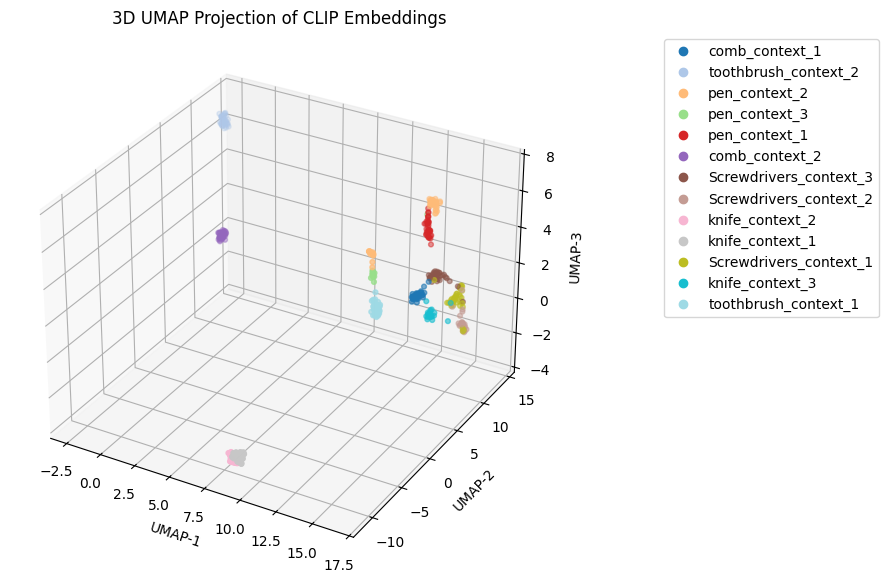

In [70]:

# Prepare all embeddings
all_vectors = []
all_labels = []

for key, arr in all_embeddings.items():
    all_vectors.append(arr)
    all_labels += [key] * arr.shape[0]

X = np.vstack(all_vectors)

# 3D UMAP
reducer = umap.UMAP(n_components=3, random_state=42)
X_3D = reducer.fit_transform(X)

# Color mapping
unique_labels = list(set(all_labels))
label_to_color = {lab: i for i, lab in enumerate(unique_labels)}
colors = [label_to_color[l] for l in all_labels]

# 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_3D[:,0], X_3D[:,1], X_3D[:,2],
                     c=colors, cmap="tab20", s=12)

# legend
handles = [
    plt.Line2D([], [], marker="o", linestyle="",
               color=scatter.cmap(scatter.norm(i)), label=lab)
    for lab, i in label_to_color.items()
]

ax.legend(handles=handles, bbox_to_anchor=(1.2, 1), loc='upper left')
ax.set_title("3D UMAP Projection of CLIP Embeddings")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.set_zlabel("UMAP-3")

plt.show()


c:\Users\surya\anaconda3\envs\myenv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


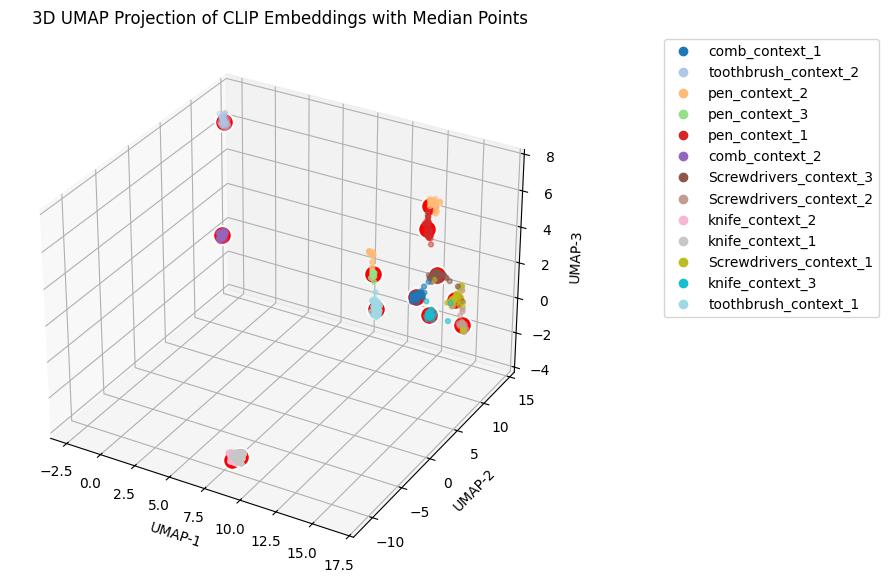

In [71]:


# Prepare all embeddings
all_vectors = []
all_labels = []
cluster_sizes = []

for key, arr in all_embeddings.items():
    all_vectors.append(arr)
    all_labels += [key] * arr.shape[0]
    cluster_sizes.append(arr.shape[0])

X = np.vstack(all_vectors)

# 3D UMAP
reducer = umap.UMAP(n_components=3, random_state=42)
X_3D = reducer.fit_transform(X)

# Color mapping
unique_labels = list(set(all_labels))
label_to_color = {lab: i for i, lab in enumerate(unique_labels)}
colors = [label_to_color[l] for l in all_labels]

# 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_3D[:,0], X_3D[:,1], X_3D[:,2],
                     c=colors, cmap="tab20", s=12)


#Median Embeddings (highlighted large points)

index = 0
for key, size in zip(unique_labels, cluster_sizes):

    # UMAP positions for this cluster
    cluster_points = X_3D[index : index + size]

    # Compute median (in 3D UMAP space)
    median_point = np.median(cluster_points, axis=0)

    # Plot median as large black point with white edge
    ax.scatter(
        median_point[0], median_point[1], median_point[2],
        color="red", edgecolors="white", s=180, marker="o", linewidth=1.5,
        label=f"{key} (median)"
    )

    index += size

# legend
handles = [
    plt.Line2D([], [], marker="o", linestyle="",
               color=scatter.cmap(scatter.norm(i)), label=lab)
    for lab, i in label_to_color.items()
]

plt.legend(handles=handles, bbox_to_anchor=(1.2, 1), loc='upper left')
ax.set_title("3D UMAP Projection of CLIP Embeddings with Median Points")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.set_zlabel("UMAP-3")

plt.show()


Plotting 3D UMAP for: comb_context_1, shape=(35, 512)


c:\Users\surya\anaconda3\envs\myenv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


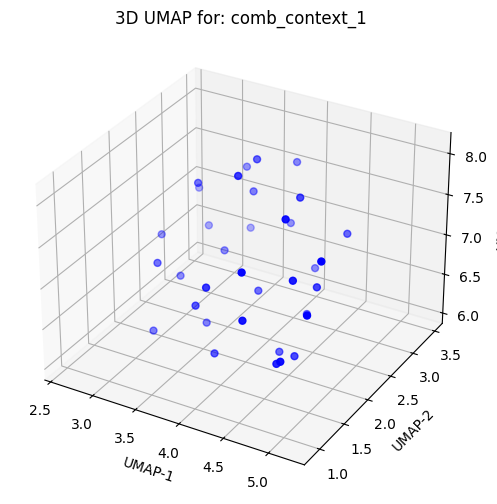

Plotting 3D UMAP for: comb_context_2, shape=(39, 512)


c:\Users\surya\anaconda3\envs\myenv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


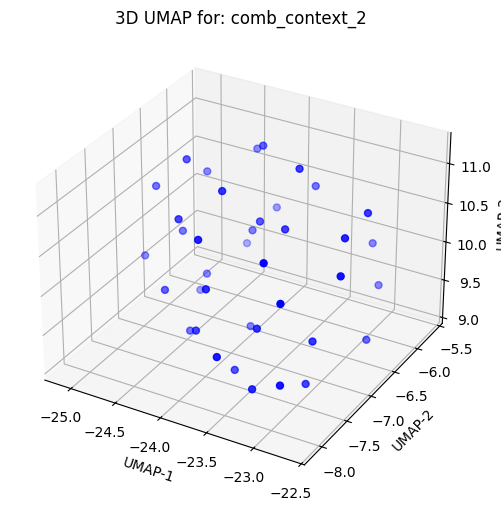

Plotting 3D UMAP for: knife_context_1, shape=(37, 512)


c:\Users\surya\anaconda3\envs\myenv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


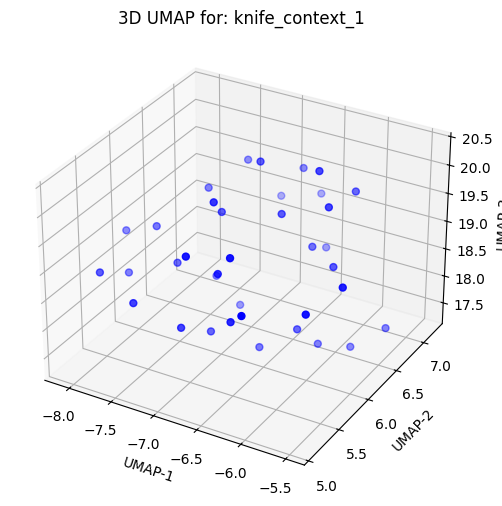

Plotting 3D UMAP for: knife_context_2, shape=(17, 512)


c:\Users\surya\anaconda3\envs\myenv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


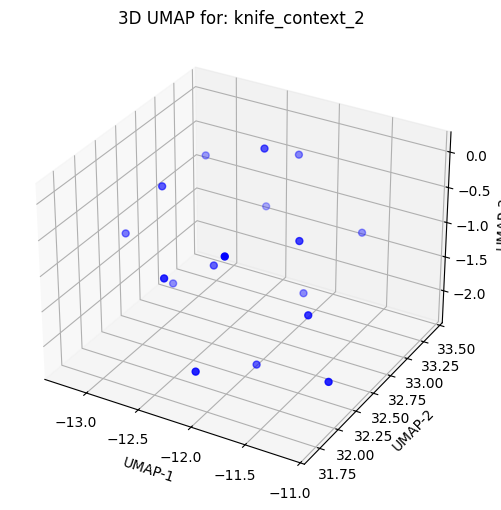

Plotting 3D UMAP for: knife_context_3, shape=(23, 512)


c:\Users\surya\anaconda3\envs\myenv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


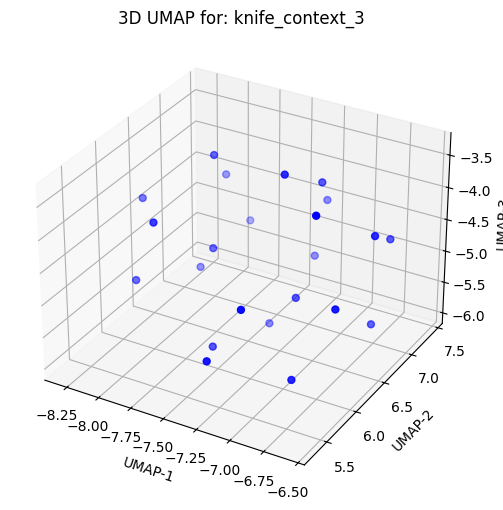

Plotting 3D UMAP for: pen_context_1, shape=(39, 512)


c:\Users\surya\anaconda3\envs\myenv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


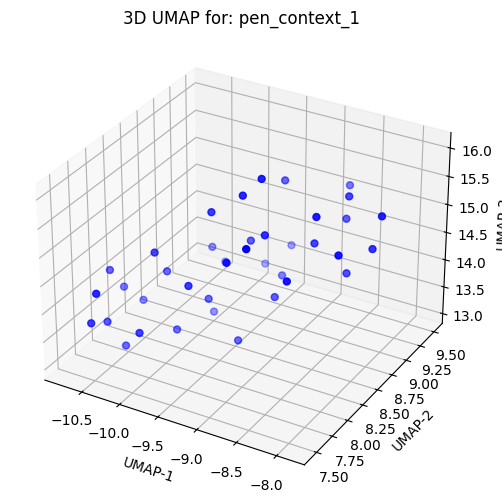

Plotting 3D UMAP for: pen_context_2, shape=(49, 512)


c:\Users\surya\anaconda3\envs\myenv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


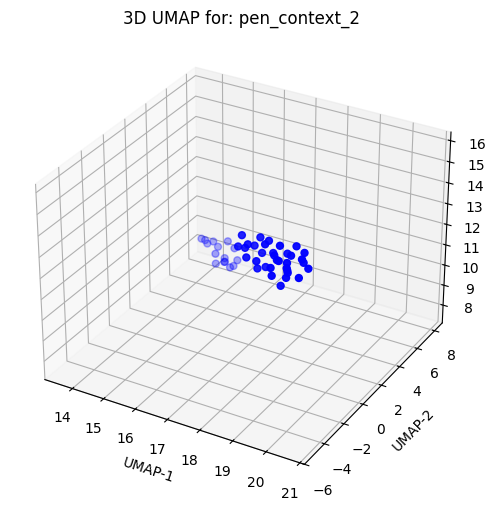

Plotting 3D UMAP for: pen_context_3, shape=(14, 512)


c:\Users\surya\anaconda3\envs\myenv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\surya\anaconda3\envs\myenv\lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


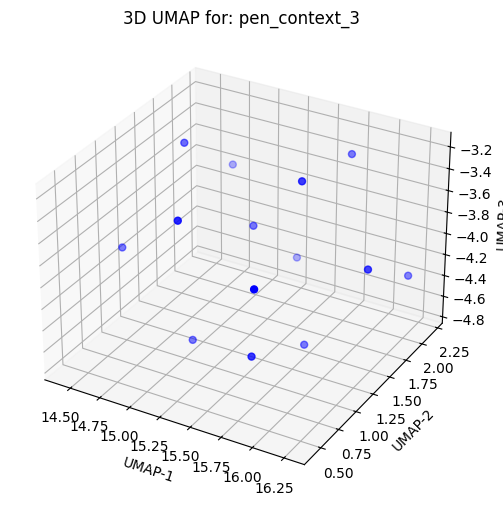

Plotting 3D UMAP for: Screwdrivers_context_1, shape=(42, 512)


c:\Users\surya\anaconda3\envs\myenv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


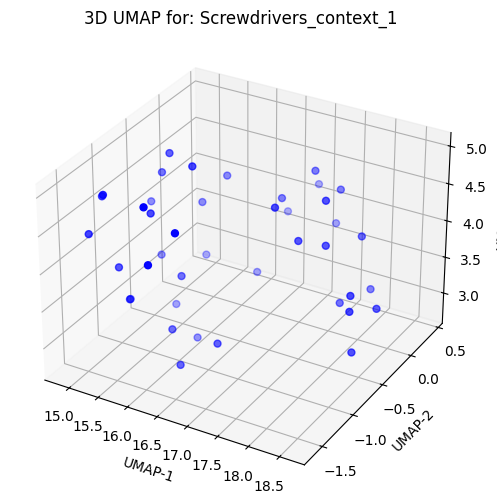

c:\Users\surya\anaconda3\envs\myenv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Plotting 3D UMAP for: Screwdrivers_context_2, shape=(26, 512)


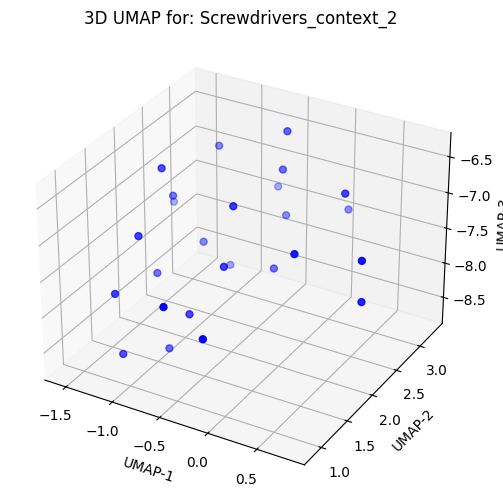

Plotting 3D UMAP for: Screwdrivers_context_3, shape=(37, 512)


c:\Users\surya\anaconda3\envs\myenv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


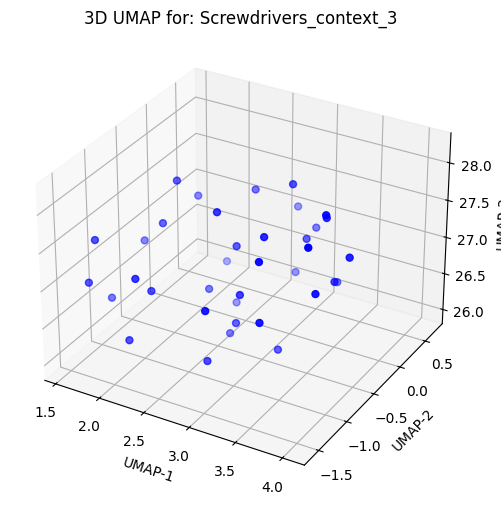

Plotting 3D UMAP for: toothbrush_context_1, shape=(39, 512)


c:\Users\surya\anaconda3\envs\myenv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


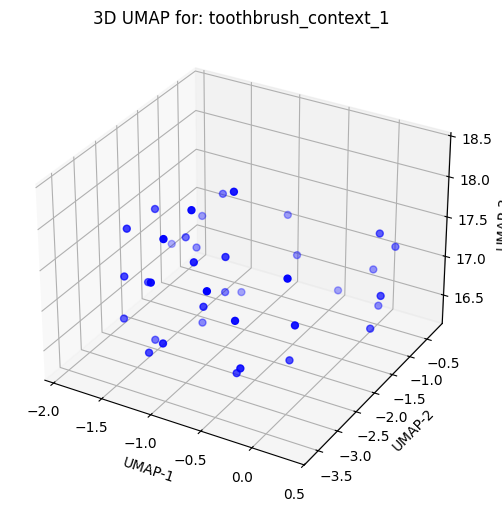

Plotting 3D UMAP for: toothbrush_context_2, shape=(38, 512)


c:\Users\surya\anaconda3\envs\myenv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


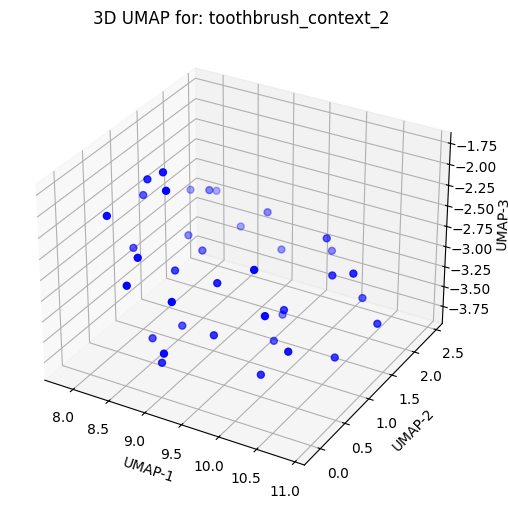

In [72]:
for key, arr in all_embeddings.items():

    print(f"Plotting 3D UMAP for: {key}, shape={arr.shape}")

    # Skip tiny clusters
    if arr.shape[0] < 3:
        print("Too few samples — skipping.\n")
        continue

    # Reduce 512 -> 3 dimensions
    reducer = umap.UMAP(n_components=3, random_state=42)
    X_3D = reducer.fit_transform(arr)

    # Plot 3D UMAP for this key
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(X_3D[:, 0], X_3D[:, 1], X_3D[:, 2], s=25, c="blue")

    ax.set_title(f"3D UMAP for: {key}")
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.set_zlabel("UMAP-3")

    plt.show()


In [73]:

median_embeddings = {}

for key, arr in all_embeddings.items():
    # arr shape = (N, 512)
    median_vec = np.median(arr, axis=0)  # shape = (512,)
    median_embeddings[key] = median_vec

# Print example
for k, v in median_embeddings.items():
    print(k, v.shape)


comb_context_1 (512,)
comb_context_2 (512,)
knife_context_1 (512,)
knife_context_2 (512,)
knife_context_3 (512,)
pen_context_1 (512,)
pen_context_2 (512,)
pen_context_3 (512,)
Screwdrivers_context_1 (512,)
Screwdrivers_context_2 (512,)
Screwdrivers_context_3 (512,)
toothbrush_context_1 (512,)
toothbrush_context_2 (512,)


In [74]:
class detection_module:

    def __init__(self, model):
        self.model = model

    def test(self, img):
        results = self.model(img, conf=0.25)
        result_list = []

        for r in results:
            if r.obb is None:
                continue

            obb = r.obb

            result_dict = {
                "cls": obb.cls.cpu().numpy().astype(int),
                "conf": obb.conf.cpu().numpy(),
                "obb": obb.xyxyxyxy.cpu().numpy()
            }

            result_list.append(result_dict)

        return result_list


In [75]:
def clip_embed_image(img_np, model, preprocess, device):
    """
    img_np: np.ndarray (H,W,3)
    returns: torch.Tensor (D,)
    """
    img_pil = Image.fromarray(img_np).convert("RGB")
    img_tensor = preprocess(img_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        emb = model.encode_image(img_tensor)
        emb = emb / emb.norm(dim=-1, keepdim=True)

    return emb.squeeze(0)


In [76]:
class hierarchical_context:

    def __init__(self, model, preprocess, device):
        self.model = model
        self.preprocess = preprocess
        self.device = device
        self.model.eval()

    def get_best_context(self, img, detections_list):
        """
        returns:
        dict {object_idx: {
            "cls": int,
            "best_context_emb": torch.Tensor (D,),
            "best_context_type": str,
            "score": float
        }}
        """

        H, W = img.shape[:2]
        assert H == 896 and W == 896

        results = {}


        if len(detections_list) == 1:
            det = detections_list[0]

            full_resized = cv2.resize(img, (224, 224))
            full_emb = clip_embed_image(
                full_resized, self.model, self.preprocess, self.device
            )

            results[0] = {
                "cls": det["cls"],
                "best_context_emb": full_emb,
                "best_context_type": "full",
                "score": 1.0
            }
            return results


        for idx, det in enumerate(detections_list):

            obb = det["obb"]
            cls_id = det["cls"]

            xs = [p[0] for p in obb]
            ys = [p[1] for p in obb]

            xmin, xmax = int(min(xs)), int(max(xs))
            ymin, ymax = int(min(ys)), int(max(ys))

            xmin, ymin = max(0, xmin), max(0, ymin)
            xmax, ymax = min(W, xmax), min(H, ymax)

            obj_crop = img[ymin:ymax, xmin:xmax]
            obj_crop = cv2.resize(obj_crop, (224, 224))

            obj_emb = clip_embed_image(
                obj_crop, self.model, self.preprocess, self.device
            )

         
            contexts = {
                "col": img[:, xmin:xmax],
                "row": img[ymin:ymax, :],
                "full": img
            }

            bw, bh = xmax - xmin, ymax - ymin
            cx, cy = (xmin + xmax)//2, (ymin + ymax)//2

            exmin = max(0, cx - bw)
            exmax = min(W, cx + bw)
            eymin = max(0, cy - bh)
            eymax = min(H, cy + bh)

            contexts["box2x"] = img[eymin:eymax, exmin:exmax]

            best_score = -1
            best_emb = None
            best_name = None

            for name, ctx in contexts.items():
                ctx_resized = cv2.resize(ctx, (224, 224))
                ctx_emb = clip_embed_image(
                    ctx_resized, self.model, self.preprocess, self.device
                )

                score = torch.dot(obj_emb, ctx_emb).item()

                if score > best_score:
                    best_score = score
                    best_emb = ctx_emb
                    best_name = name

            results[idx] = {
                "cls": cls_id,
                "best_context_emb": best_emb, 
                "best_context_type": best_name,
                "score": best_score
            }

        return results


In [77]:
classes_dict = {

0:"screwdriver",
1:"comb",
2:"knife",
3:"pen",
4:"toothbrush"


}

In [91]:
best_weights_path = r"C:\Users\surya\Desktop\computer vision\Hopfield networks\obb\train4\weights\best.pt"

yolo_model = YOLO(best_weights_path)
image = cv2.imread(r"C:\Users\surya\Desktop\computer vision\Hopfield networks\overlay-image.jpg")
image = cv2.resize(image,(896,896))
detector = detection_module(yolo_model)
results = detector.test(image)
print(results)



0: 256x256 1 pen, 47.6ms
Speed: 15.1ms preprocess, 47.6ms inference, 11.4ms postprocess per image at shape (1, 3, 256, 256)
[{'cls': array([3]), 'conf': array([    0.47339], dtype=float32), 'obb': array([[[     638.05,      827.86],
        [     764.37,      159.97],
        [     699.39,      147.68],
        [     573.07,      815.57]]], dtype=float32)}]


In [79]:
hier_context_module = hierarchical_context(model,preprocess,device)
best_contexts = hier_context_module.get_best_context(image,results)

In [80]:
best_contexts

{0: {'cls': array([0]),
  'best_context_emb': tensor([-2.8061e-02,  8.1100e-03, -4.4894e-04,  4.6539e-02,  2.1561e-02, -2.0630e-02, -4.1237e-03,  2.3727e-02, -4.0741e-03,  1.1246e-02, -2.8290e-02, -2.7557e-02,  8.9722e-02, -2.9724e-02,  1.8188e-02, -1.1246e-02, -4.9896e-02,  1.6449e-02,  5.2612e-02, -3.3112e-02,  2.0691e-02,  1.9722e-03,  6.8550e-03, -2.4445e-02,
          -5.1178e-02, -1.5518e-02,  1.5068e-02, -4.1748e-02,  2.8076e-02, -3.9948e-02,  7.0648e-03,  1.7654e-02,  2.4246e-02, -2.9633e-02, -2.2293e-02,  5.1849e-02,  3.6377e-02,  2.0447e-02,  1.7563e-02, -4.0253e-02, -1.7731e-02,  3.4088e-02, -3.4065e-03, -8.8167e-04,  1.7365e-02, -2.6917e-02,  1.1223e-02,  2.5391e-02,
          -7.9193e-03, -1.2001e-02,  3.3844e-02,  2.5345e-02, -1.4277e-03,  2.9541e-02,  3.2410e-02,  1.6022e-02, -8.4229e-03, -9.6846e-04, -1.8906e-02,  3.9642e-02,  3.9459e-02, -4.3579e-02, -1.3252e-02,  1.8768e-02,  5.4002e-05,  4.2084e-02, -3.7537e-02,  4.5166e-02,  1.6602e-02,  3.0136e-02, -3.6377e-02,  5.

c:\Users\surya\anaconda3\envs\myenv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


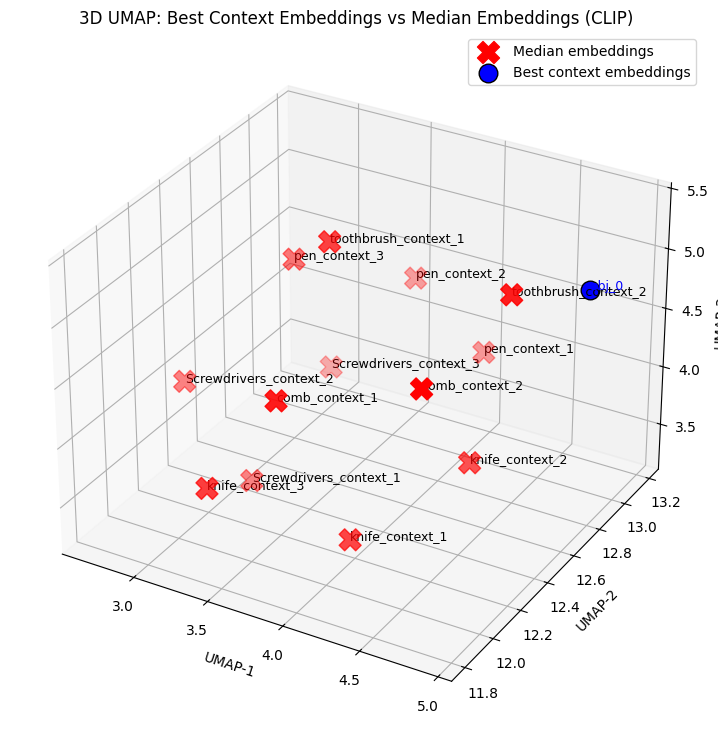

In [81]:

context_keys = list(best_contexts.keys())
context_embs = []

for k in context_keys:
    emb = best_contexts[k]["best_context_emb"]
    if isinstance(emb, torch.Tensor):
        emb = emb.detach().cpu().numpy()
    context_embs.append(emb)

context_matrix = np.stack(context_embs)   # (Nc, D)


median_keys = list(median_embeddings.keys())
median_matrix = np.stack([
    median_embeddings[k] if isinstance(median_embeddings[k], np.ndarray)
    else median_embeddings[k].detach().cpu().numpy()
    for k in median_keys
])  # (Nm, D)

all_embeddings = np.vstack([median_matrix, context_matrix])

reducer = umap.UMAP(
    n_components=3,
    n_neighbors=10,
    min_dist=0.1,
    metric="cosine",
    random_state=42
)

all_3d = reducer.fit_transform(all_embeddings)

median_3d = all_3d[:len(median_keys)]
context_3d = all_3d[len(median_keys):]

fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    median_3d[:, 0],
    median_3d[:, 1],
    median_3d[:, 2],
    s=250,
    c="red",
    marker="X",
    label="Median embeddings"
)

for i, key in enumerate(median_keys):
    ax.text(
        median_3d[i, 0],
        median_3d[i, 1],
        median_3d[i, 2],
        key,
        fontsize=9,
        color="black"
    )

ax.scatter(
    context_3d[:, 0],
    context_3d[:, 1],
    context_3d[:, 2],
    s=180,
    c="blue",
    marker="o",
    edgecolors="black",
    label="Best context embeddings"
)

# Annotate contexts
for i, obj_id in enumerate(context_keys):
    label = f"obj_{obj_id}"
    ax.text(
        context_3d[i, 0],
        context_3d[i, 1],
        context_3d[i, 2],
        label,
        fontsize=9,
        color="blue"
    )

ax.set_title("3D UMAP: Best Context Embeddings vs Median Embeddings (CLIP)")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.set_zlabel("UMAP-3")
ax.legend()

plt.show()



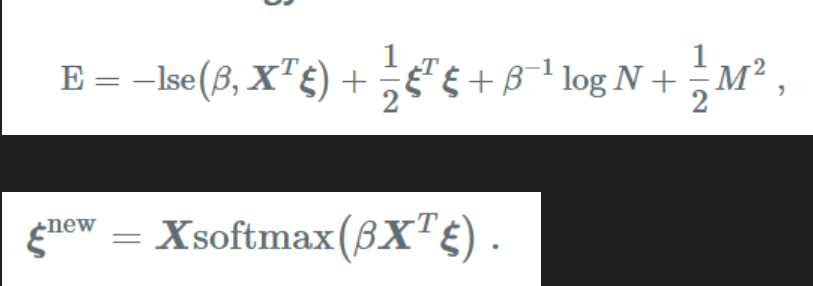

In [82]:
Beta = 8

X = torch.tensor(median_matrix, dtype=torch.float32)      # (13, 512)
Query = torch.tensor(context_matrix, dtype=torch.float32) # (1, 512)

scores = Beta * torch.matmul(X, Query.T).squeeze()  # (13,)

weights = F.softmax(scores, dim=0)                  # (13,)

xi_new = torch.matmul(weights, X)                   # (512,)

print(xi_new.shape)  # torch.Size([512])


torch.Size([512])


In [83]:
objects_predictions =[]

for context_id,contexts in best_contexts.items():

    objects_predictions.append(classes_dict[int(best_contexts[context_id]['cls'][0])])

In [ ]:
text_tokens = clip.tokenize(objects_predictions).to(device)

with torch.no_grad():
    text_embeddings = model.encode_text(text_tokens)

text_embeddings = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)

print(text_embeddings.shape)


torch.Size([1, 512])


In [85]:
Beta = 8

X = torch.tensor(median_matrix, dtype=torch.float32).to(device)    # (13, 512)
Query = torch.tensor(text_embeddings, dtype=torch.float32).to(device) # (1, 512)

scores = Beta * torch.matmul(X, Query.T).squeeze()  # (13,)

weights = F.softmax(scores, dim=0)                  # (13,)

xi2_new = torch.matmul(weights, X)                   # (512,)

print(xi2_new.shape)  # torch.Size([512])

torch.Size([512])


C:\Users\surya\AppData\Local\Temp\ipykernel_40772\3842030992.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Query = torch.tensor(text_embeddings, dtype=torch.float32).to(device) # (1, 512)


In [86]:
sim = cosine_similarity(xi_new.cpu().numpy().reshape(1,-1),xi2_new.cpu().numpy().reshape(1,-1))

print(sim)       
print(sim[0, 0])  

[[    0.75515]]
0.7551458


In [87]:
if(sim[0,0]>0.9):
    print("Correct predictions")

In [88]:
import pickle

# Save the matrix to a file
with open('median_matrix.pkl', 'wb') as f:
    pickle.dump(median_matrix, f)

print("Saved median_matrix.pkl")

Saved median_matrix.pkl
